In [9]:
%matplotlib notebook

import os
import time
import numpy as np
import matplotlib as mpl
import sys
from importlib import reload

In [10]:
import qcodes as qc
from broadbean.plotting import plotter

In [11]:
from pytopo.qctools.instruments import create_inst, add2station
from pytopo.qctools.dataset2 import select_experiment

from plottr import client
from plottr.qcodes_dataset import QcodesDatasetSubscriber
from plottr.qcodes_dataset import QcodesDatasetSubscriber as LivePlotSubscriber

from pytopo.mplplots.init_nb_plotting import *

qc.config['core']['db_location'] = r"d:/OneDrive/BF2/Data/experiments.db"
qc.dataset.database.initialise_database()

In [12]:
from qcodes import load_by_id
from qcodes import validators
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.database import initialise_database
from qcodes.instrument.base import Instrument
from qcodes.instrument.parameter import Parameter
from qcodes.dataset.plotting import plot_by_id
from qcodes.utils.validators import Numbers

In [13]:
import qcodes as qc
import broadbean as bb

from broadbean.plotting import plotter

In [14]:
from pytopo.qctools import hard_sweep; reload(hard_sweep)
from pytopo.qctools.hard_sweep import HardSweep, HardSweepDetector

In [15]:
ramp = bb.PulseAtoms.ramp

In [16]:
from pytopo.qctools import instruments as instools; reload(instools)
from pytopo.qctools.instruments import create_inst, add2station
from pytopo.qctools.dataset2 import select_experiment
from pytopo.qctools.measurement import MeasurementExt

from pytopo.rf import alazar_detector; reload(alazar_detector)
from pytopo.rf.alazar_detector import AlazarDetector

from plottr import qcodes_dataset; reload(qcodes_dataset)
from plottr.qcodes_dataset import QcodesDatasetSubscriber

from cqed import broadbean; reload(broadbean)
from cqed.broadbean import BroadBeanSequence, BluePrints

from cqed import bb_sequences; reload(bb_sequences)
from cqed.bb_sequences import TriggeredReadoutSequence



In [18]:
class AWGGateRamp1D(BroadBeanSequence):
    
    trigger_delay = 100e-9
    alazar_trigger_len = 100e-9
    sweep_dims = ['voltages', ]

    
    def __init__(self, *arg, **kw):
        super().__init__(*arg, **kw)
        
        self.add_parameter('initial_delay', set_cmd=None, 
                           unit='s', initial_value=10e-6)
        self.add_parameter('step_len', set_cmd=None, 
                           unit='s', initial_value=10e-6)
        self.add_parameter('start_voltage', set_cmd=None,
                           unit='V', initial_value=0)
        self.add_parameter('stop_voltage', set_cmd=None,
                           unit='V', initial_value=1)
        self.add_parameter('voltage_points', set_cmd=None,
                           unit='', initial_value=11)
        self.add_parameter('ramp_down_time', set_cmd=None,
                           unit='s', initial_value=10e-6)
        
    def setup(self, **kw):
        vpts = np.linspace(self.start_voltage(), self.stop_voltage(), self.voltage_points())
        self.voltages(vpts)
        super().setup(**kw)
        
        
    def sequence(self):
        elem = bb.Element()
        bps = BluePrints(self.chan_map, sample_rate=self.sample_rate())
        
        cut_t = 0
        bps['ro_trigger'] = []
        bps['awg_voltage'].insertSegment(0, ramp, (self.start_voltage(), self.start_voltage()), 
                                         dur=self.initial_delay(), name='voltage')        
        for i, v in enumerate(self.voltages()):
            bps['awg_voltage'].insertSegment(i+1, ramp, (v, v), 
                                             dur=self.step_len(), name='voltage')
            bps['ro_trigger'].append((self.initial_delay() + self.step_len() * i + self.trigger_delay, 
                                      self.alazar_trigger_len))
            
        bps['awg_voltage'].insertSegment(-1, ramp, (v, self.start_voltage()), 
                                         dur=self.ramp_down_time(), name='voltage')        

        for n, bp in bps():
            elem.addBluePrint(n, bp)
            
        seq = bb.Sequence()
        seq.name = 'v_ramp'
        seq.addElement(1, elem)
        
        return seq
        

In [19]:
BroadBeanSequence.chan_map = {
    1 : ['awg_voltage', 'ro_trigger', None],
}
BroadBeanSequence.chan_settings[1]['Vpp'] = 1.0
BroadBeanSequence.chan_settings[1]['marker_hi'] = [1.5, 1.5, 1.5, 1.5]
BroadBeanSequence.chan_settings[1]['marker_lo'] = [-0.3, -0.3, -0.3, -0.3]
BroadBeanSequence.sweep_wait = None

TriggeredReadoutSequence.chan_map = {
    1 : ['FILL.1', 'ro_trigger', None],
}

### Instruments init

In [17]:
sys.path.append('D:/OneDrive/BF2/Code')
from RIGOL.RIGOL_driver import DG1062
fg = DG1062(name = 'fg', address = 'USB0::0x1AB1::0x0642::DG1ZA195006391::INSTR')

Connected to: Rigol Technologies DG1062Z (serial:DG1ZA195006391, firmware:03.01.12) in 0.75s


In [28]:
from qcodes.instrument_drivers.stanford_research.SR860 import SR860
from qcodes.instrument_drivers.stanford_research.SR86x import SR86x

lockin1 = create_inst(SR860, "lockin1", "GPIB0::3::INSTR")
lockin2 = create_inst(SR860, "lockin2", "GPIB0::4::INSTR")
lockin3 = create_inst(SR860, "lockin3", "GPIB0::5::INSTR")

station.add_component(lockin1)
station.add_component(lockin2)
station.add_component(lockin3)

Connected to: Stanford_Research_Systems SR860 (serial:003105, firmware:V1.47) in 0.05s
Connected to: Stanford_Research_Systems SR860 (serial:003224, firmware:V1.47) in 0.06s
Connected to: Stanford_Research_Systems SR860 (serial:003218, firmware:V1.47) in 0.05s


'lockin3'

In [20]:
from qcodes.instrument_drivers.tektronix.AWG5208 import AWG5208
awg = create_inst(AWG5208, "awg", address='TCPIP0::169.254.121.32::inst0::INSTR')
station = qc.Station(awg)

# Alazar
from qcodes.instrument_drivers.AlazarTech import utils; reload(utils)
from qcodes.instrument_drivers.AlazarTech import ATS9360; reload(ATS9360)
from qcodes.instrument_drivers.AlazarTech.ATS9360 import AlazarTech_ATS9360
alazar = create_inst(AlazarTech_ATS9360, 'alazar', force_new_instance=True)
station = add2station(station, alazar)

# Alazar aquisition controllers
from pytopo.rf import alazar_acquisition; reload(alazar_acquisition)
from pytopo.rf.alazar_acquisition import RawAcqCtl, AvgDemodCtl, AvgIQCtl

raw_acq = create_inst(RawAcqCtl, 'raw_acq', 'alazar', force_new_instance=True)
station = add2station(station, raw_acq)

avgdemod_acq = create_inst(AvgDemodCtl, 'avgdemod_acq', 'alazar', force_new_instance=True)
station = add2station(station, avgdemod_acq)

avgiq_acq = create_inst(AvgIQCtl, 'avgiq_acq', 'alazar', force_new_instance=True)
station = add2station(station, avgiq_acq)

# RF sources
from qcodes.instrument_drivers.rohde_schwarz.SGS100A import RohdeSchwarz_SGS100A
LO = create_inst(RohdeSchwarz_SGS100A, 'LO', address="TCPIP0::169.254.2.20", force_new_instance=True)
station = add2station(station, LO)

RF = create_inst(RohdeSchwarz_SGS100A, 'RF', address="TCPIP0::169.254.231.38", force_new_instance=True)
station = add2station(station, RF)

#from qcodes.instrument_drivers.agilent.E8267C import E8267
#S1 = instools.create_inst(E8267, 'S1', address='GPIB0::19::INSTR', force_new_instance=True)
#inst_list.append(S1)

from pytopo.rf.sources import HeterodyneSource
hetsrc = create_inst(HeterodyneSource, 'hetsrc', RF=RF, LO=LO, force_new_instance=True)
station = add2station(station, hetsrc)

awg.wfmxFileFolder = "\\Users\\MSFTE\\Documents"
awg.seqxFileFolder = "\\Users\\MSFTE\\Documents"

Connected to: TEKTRONIX AWG5208 (serial:B020237, firmware:FV:6.1.0054.0) in 0.12s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110509, firmware:3.1.19.15-3.50.124.67) in 0.04s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110510, firmware:3.1.19.15-3.50.124.67) in 0.03s


In [21]:
def awg_trigger_func(do_start):
    if do_start:
        station.awg.play()
    else:
        station.awg.stop()
        
for ctl in [raw_acq, avgdemod_acq, avgiq_acq]:
    ctl.trigger_func = awg_trigger_func

In [14]:
from qcodes.instrument_drivers.american_magnetics.AMI430 import AMI430,AMI430_3D
ami_x = create_inst(AMI430, "AMI430_x", "169.254.158.77", port = 7180, has_current_rating=True)
ami_y = create_inst(AMI430, "AMI430_y", "169.254.208.179", port = 7180, has_current_rating=True)
ami_z = create_inst(AMI430, "AMI430_z", "169.254.88.255", port = 7180, has_current_rating=True)


ami = create_inst(AMI430_3D, "AMI430", ami_x, ami_y, ami_z, 2)



station.add_component(ami_x)
station.add_component(ami_y)
station.add_component(ami_z)
station.add_component(ami)

Connected to: AMERICAN MAGNETICS INC. 430 (serial:2.01, firmware:None) in 0.81s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:2.01, firmware:None) in 1.00s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:2.01, firmware:None) in 0.81s


'AMI430'

In [41]:
ami.field_measured()

1.0000000000000001e-05

In [15]:
from qcodes.instrument_drivers.QuTech.IVVI import IVVI
ivvi = create_inst(IVVI, "ivvi", "ASRL4::INSTR")

Initialized IVVI-rack in 0.03s


In [37]:
station.add_component(ivvi)

for i in range(1,16):
    ivvi.parameters['dac{}'.format(i)].set_step(0.5)
    ivvi.parameters['dac{}'.format(i)].set_delay(0.001)
    
ivvi.dac1.set_delay(0.001)
ivvi.dac1.set_step(20)

ivvi.dac2.set_delay(0.001)
ivvi.dac2.set_step(20)

ivvi.dac3.set_delay(0.001)
ivvi.dac3.set_step(2)

ivvi.dac4.set_delay(0.001)
ivvi.dac4.set_step(20)

ivvi.dac5.set_delay(0.001)
ivvi.dac5.set_step(60)

ivvi.dac6.set_delay(0.001)
ivvi.dac6.set_step(2)

ivvi.dac6.set_delay(0.001)
ivvi.dac6.set_step(20)

ivvi.dac7.set_delay(0.0001)
ivvi.dac7.set_step(60)

ivvi.dac8.set_delay(0.001)
ivvi.dac8.set_step(20)

ivvi.dac9.set_delay(0.001)
ivvi.dac9.set_step(60)


d:\code\qcodes\qcodes\instrument\parameter.py:577: UserWarning: set_step is deprecated use step property as in `inst.step = stepvalue` instead
  "set_step is deprecated use step property as in `inst.step = "
d:\code\qcodes\qcodes\instrument\parameter.py:589: UserWarning: set_delay is deprecated use inter_delay or post_delay property as in `inst.inter_delay = delayvalue` instead
  "set_delay is deprecated use inter_delay or post_delay property "


In [17]:
from qcodes.instrument_drivers.yokogawa.GS200 import GS200
yoko = create_inst(GS200, "yoko", "GPIB0::1::INSTR")

yoko.voltage_range(0.01)
yoko.voltage(0)
yoko.current_limit(1e-3)
yoko.on()

Connected to: YOKOGAWA GS210 (serial:91T926459, firmware:2.02) in 0.06s


In [18]:
class ConversionParameter(Parameter):
    
    def __init__(self, name, src_param, get_conv, set_conv=None, **kw):
        super().__init__(name, **kw)
        self.src_param = src_param
        self.get_conv = get_conv
        self.set_conv = set_conv
    
    def get_raw(self):
        return self.get_conv(self.src_param())
    
    def set_raw(self, value):
        if self.set_conv is None:
            raise NotImplementedError("No set conversion implemented.")
        
        return self.src_param(self.set_conv(value))
    

class IVVISetup(Instrument):
    
    def __init__(self, name, ivvi, **kw):
        super().__init__(name, **kw)
        
        self.ivvi = ivvi
        
        self.add_parameter('voltage_multiplier', get_cmd=None, set_cmd=None, 
                           initial_value=1e-3)
        self.add_parameter('current_multiplier', get_cmd=None, set_cmd=None, 
                           initial_value=1e-7)
        self.add_parameter('iso_in_multiplier', get_cmd=None, set_cmd=None,
                           initial_value=1e-2)
        self.add_parameter('gate_multiplier', get_cmd=None, set_cmd=None, 
                           initial_value=15)
        
        self.add_parameter('M1b_gain', get_cmd=None, set_cmd=None, initial_value=1e6)
        self.add_parameter('M1b_mode', get_cmd=None, set_cmd=None, 
                           vals=validators.Enum('low_noise', 'low_R_in'), 
                           initial_value='low_noise')
        self.add_parameter('M1b_R_in', get_cmd=self._get_M1b_R_in)
        
        self.add_parameter('M2m_Vgain', get_cmd=None, set_cmd=None, initial_value=1e3)

        for i in range(1, self.ivvi._numdacs + 1):       
            self.add_parameter('dac{}'.format(i), unit='V',
                               get_cmd=self.ivvi._gen_ch_get_func(self._get_dac, i),
                               set_cmd=self.ivvi._gen_ch_set_func(self._set_dac, i))
            
    def _get_M1b_R_in(self):
        if self.M1b_mode() == 'low_noise':
            return 2e3 + 1e-3 * self.M1b_gain()
        elif self.M1b_mode() == 'low_R_in':
            return 2e3 + 1e-4 * self.M1b_gain()
            
    def _get_dac(self, ch):
        if ch == 6:
            return self.ivvi.set('dac{}'.format(ch)) * 1e-3 * self.gate_multiplier()
        else:
            return self.ivvi.get('dac{}'.format(ch)) * 1e-3 * self.voltage_multiplier()
    
    def _set_dac(self, ch, val):
        if ch == 3:
            return self.ivvi.set('dac{}'.format(ch), val * 1e3 / self.gate_multiplier())
        else:
            return self.ivvi.set('dac{}'.format(ch), val * 1e3 / self.voltage_multiplier())
    


In [19]:
ivvi_setup = create_inst(IVVISetup, 'ivvi_setup', ivvi=ivvi, force_new_instance=True)
ivvi_setup.voltage_multiplier(10e-3)
#ivvi_setup.voltage_multiplier(100e-9)
ivvi_setup.gate_multiplier(15)

In [61]:
ivvi_setup.dac3(-6.5)
ivvi.dac6(50)
ivvi.dac7(-400)

In [39]:
plungers = np.linspace(-400, 200, 101)

In [ ]:
SAMPLE = 'Frank'

In [22]:
with alazar.syncing():
    alazar.clock_source('INTERNAL_CLOCK')
    alazar.sample_rate(int(0.2e9))
    alazar.clock_edge('CLOCK_EDGE_RISING')
    alazar.external_sample_rate(int(1e9))
    alazar.decimation(1)
    alazar.coupling1('DC')
    alazar.coupling2('DC')
    alazar.channel_range1(0.4)
    alazar.channel_range2(0.4)
    alazar.impedance1(50)
    alazar.impedance2(50)
    alazar.trigger_source1('EXTERNAL')
    alazar.trigger_level1(128 + 20)
    alazar.external_trigger_coupling('DC')
    alazar.external_trigger_range('ETR_2V5')
    alazar.trigger_delay(0)
    alazar.timeout_ticks(int(1e7))

d:\onedrive\bf2\code\qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py:564: UserWarning: Using Internal clock but parameter external_sample_rate is set.This will have no effect and is ignored
  warnings.warn("Using Internal clock but parameter external_sample_rate is set."


### Software sweep

In [27]:
setup_awg = True
int_time = 0.1e-3
buffer_len = 100e-6
acq = avgiq_acq
acq.trigger_func = None

# create new instance of sequence and detector
sequence = create_inst(TriggeredReadoutSequence, 'sequence', awg=awg, force_new_instance=True)
station = add2station(station, sequence)
detector = create_inst(AlazarDetector, name='detector', acqctl=acq, force_new_instance=True)
station = add2station(station, detector)

# configure the sequence parameters
sequence.pre_trigger_delay(1e-6) # some delay at the beginning
sequence.trigger_len(100e-9) # short trigger for the alazar
sequence.seq_len(10e-6) # quick rep-rate is OK here
if setup_awg:
    sequence.setup(program_awg=True, start_awg=True) # program and start only if something else is running before
else:
    sequence.setup(program_awg=False, start_awg=False)
    
# configure the Alazar detector
detector.set_sweeper(sequence) # set the sequence (it's just one dummy sweep-point here)
detector.demod_frq(hetsrc.IF()) # demod frequency from the sources
detector.acq_time(buffer_len) # not too long integration time ber buffer
detector.configure_alazar(
    records_per_buffer=1,
    buffers_per_acquisition=int(int_time/buffer_len), # set averaging by choosing the number of buffers
)
detector.setup()



No ro_gate defined in channel map. No readout gate pulse will be generated.
No src_gate defined in channel map. No src gate pulse will be generated.


Instrument sequence already exists.
Instrument detector already exists.
Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]


In [28]:
a

[array([[ -1.52746703e-05 -6.19920516e-05j,
          -3.49628715e-05 -4.55404055e-06j]]),
 array([[  4.63942786e-05 -3.14364402e-05j,
          -2.70809237e-06 -2.71462914e-05j]]),
 array([[ -3.71975664e-05 -4.42246006e-05j,
          -3.06208537e-05 +6.03798756e-06j]]),
 array([[  6.17417876e-05 +1.89643009e-07j,
           1.52095633e-05 -1.28818921e-05j]]),
 array([[ -2.74570871e-05 +5.04415709e-05j,
           1.90493093e-05 +2.75240062e-05j]]),
 array([[  6.25642992e-05 +2.25237290e-05j,
           2.29675848e-05 -1.95882335e-05j]]),
 array([[  5.73215778e-05 +1.85280670e-05j,
           8.09075332e-06 -1.99464104e-05j]]),
 array([[  2.17233715e-05 -5.65210119e-05j,
          -1.65011358e-05 -2.91066053e-05j]]),
 array([[ -2.30465740e-05 -6.45556142e-05j,
          -2.63229400e-05 -6.25715262e-06j]]),
 array([[ -3.41488064e-05 +4.59211661e-05j,
           4.76347525e-06 +2.75107487e-05j]]),
 array([[ -2.89650017e-05 -5.41339445e-05j,
          -4.52067438e-05 -2.08589069e-06j]]),

In [ ]:
### Test

rf_frqs = np.linspace(150e6, 250e6, 201)[:] # spec frequencies
plungervals = np.linspace(0, 400, 101)
# ro_atts = np.arange(26, 42, 2)
setup_awg = True
int_time = 0.1e-3
buffer_len = 100e-6


### End User settings


### Setting up instruments

# set IQ acquisition controller
acq = avgiq_acq
acq.trigger_func = None

# create new instance of sequence and detector
sequence = create_inst(TriggeredReadoutSequence, 'sequence', awg=awg, force_new_instance=True)
station = add2station(station, sequence)
detector = create_inst(AlazarDetector, name='detector', acqctl=acq, force_new_instance=True)
station = add2station(station, detector)

# configure the sequence parameters
sequence.pre_trigger_delay(1e-6) # some delay at the beginning
sequence.trigger_len(100e-9) # short trigger for the alazar
sequence.seq_len(10e-6) # quick rep-rate is OK here
if setup_awg:
    sequence.setup(program_awg=True, start_awg=True) # program and start only if something else is running before
else:
    sequence.setup(program_awg=False, start_awg=False)
    
# configure the Alazar detector
detector.set_sweeper(sequence) # set the sequence (it's just one dummy sweep-point here)
detector.demod_frq(hetsrc.IF()) # demod frequency from the sources
detector.acq_time(buffer_len) # not too long integration time ber buffer
detector.configure_alazar(
    records_per_buffer=1,
    buffers_per_acquisition=int(int_time/buffer_len), # set averaging by choosing the number of buffers
)
detector.setup() # this makes sure all params are set correctly

### Set up the measurement info
exp = select_experiment('resonator_spec', 'dev48') # select experiment (info for the database)

# need to make sure the sweep is correctly described in the beginning!
meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          hetsrc.frequency,
                          ivvi.dac7
#                           ro_attenuator.attenuation,
                      ],
                     )

#meas.register_parameter(ivvi.dac7)
# and finally, the measurement loop
meas.write_period = 2 # how often to write to the DB [s]
with meas.run() as datasaver:
    
    # this is to connect the database to the plottr.
    plot_subscriber = QcodesDatasetSubscriber(datasaver.dataset)
    datasaver.dataset.subscribe(plot_subscriber, state=[])
    
    # the loop itself is trivial
#     for att in ro_atts:
#         ro_attenuator.attenuation(att)
    for p in plungervals:
        ivvi.dac7(p)
        for f in rf_frqs:
            hetsrc.frequency(f)
            time.sleep(0.01)

            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result()) # this adds all data to the datasaver.

In [18]:
ivvi_setup.dac3(-6.5)
ivvi.dac6(50)
ivvi.dac7(-400)

plungers = np.linspace(-400, -50, 101)

In [24]:
hetsrc.frequency(2.33e8)
hetsrc.IF(1e6)
hetsrc.RF.on()
hetsrc.LO.on()
hetsrc.RF.power(-40)
hetsrc.LO.power(10)

In [22]:
hetsrc.IF(1e6)

In [90]:
### User settings

rf_frqs = np.linspace(150e6, 250e6, 201)[:] # spec frequencies
plungervals = np.linspace(0, 400, 101)
# ro_atts = np.arange(26, 42, 2)
setup_awg = True
int_time = 0.1e-3
buffer_len = 100e-6


### End User settings


### Setting up instruments

# set IQ acquisition controller
acq = avgiq_acq
acq.trigger_func = None

# create new instance of sequence and detector
sequence = create_inst(TriggeredReadoutSequence, 'sequence', awg=awg, force_new_instance=True)
station = add2station(station, sequence)
detector = create_inst(AlazarDetector, name='detector', acqctl=acq, force_new_instance=True)
station = add2station(station, detector)

# configure the sequence parameters
sequence.pre_trigger_delay(1e-6) # some delay at the beginning
sequence.trigger_len(100e-9) # short trigger for the alazar
sequence.seq_len(10e-6) # quick rep-rate is OK here
if setup_awg:
    sequence.setup(program_awg=True, start_awg=True) # program and start only if something else is running before
else:
    sequence.setup(program_awg=False, start_awg=False)
    
# configure the Alazar detector
detector.set_sweeper(sequence) # set the sequence (it's just one dummy sweep-point here)
detector.demod_frq(hetsrc.IF()) # demod frequency from the sources
detector.acq_time(buffer_len) # not too long integration time ber buffer
detector.configure_alazar(
    records_per_buffer=1,
    buffers_per_acquisition=int(int_time/buffer_len), # set averaging by choosing the number of buffers
)
detector.setup() # this makes sure all params are set correctly

### Set up the measurement info
exp = select_experiment('resonator_spec', 'dev48') # select experiment (info for the database)

# need to make sure the sweep is correctly described in the beginning!
meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          hetsrc.frequency,
                          ivvi.dac7
#                           ro_attenuator.attenuation,
                      ],
                     )

#meas.register_parameter(ivvi.dac7)
# and finally, the measurement loop
meas.write_period = 2 # how often to write to the DB [s]
with meas.run() as datasaver:
    
    # this is to connect the database to the plottr.
    plot_subscriber = QcodesDatasetSubscriber(datasaver.dataset)
    datasaver.dataset.subscribe(plot_subscriber, state=[])
    
    # the loop itself is trivial
#     for att in ro_atts:
#         ro_attenuator.attenuation(att)
    for p in plungervals:
        ivvi.dac7(p)
        for f in rf_frqs:
            hetsrc.frequency(f)
            time.sleep(0.01)

            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result()) # this adds all data to the datasaver.

No ro_gate defined in channel map. No readout gate pulse will be generated.
No src_gate defined in channel map. No src gate pulse will be generated.


Instrument sequence already exists.
Instrument detector already exists.
Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Starting experimental run with id: 567


KeyboardInterrupt: 

In [30]:
#biasvals = np.linspace(-400e-6, 400e-6, 101)
plungervals = np.linspace(-500, 600, 401)

setup_awg = True
int_time = 0.1e-3
buffer_len = 100e-6

hetsrc.frequency(233e6)
### End User settings


### Setting up instruments

# set IQ acquisition controller
acq = avgiq_acq
acq.trigger_func = awg_trigger_func#None

# create new instance of sequence and detector
sequence = create_inst(TriggeredReadoutSequence, 'sequence', awg=awg, force_new_instance=True)
station = add2station(station, sequence)
detector = create_inst(AlazarDetector, name='detector', acqctl=acq, force_new_instance=True)
station = add2station(station, detector)

# configure the sequence parameters
sequence.pre_trigger_delay(1e-6) # some delay at the beginning
sequence.trigger_len(100e-9) # short trigger for the alazar
sequence.seq_len(10e-6) # quick rep-rate is OK here
if setup_awg:
    sequence.setup(program_awg=True, start_awg=True) # program and start only if something else is running before
else:
    sequence.setup(program_awg=False, start_awg=False)
    
# configure the Alazar detector
detector.set_sweeper(sequence) # set the sequence (it's just one dummy sweep-point here)
detector.demod_frq(hetsrc.IF()) # demod frequency from the sources
detector.acq_time(buffer_len) # not too long integration time ber buffer
detector.configure_alazar(
    records_per_buffer=1,
    buffers_per_acquisition=int(int_time/buffer_len), # set averaging by choosing the number of buffers
)
detector.setup() # this makes sure all params are set correctly

### Set up the measurement info
exp = select_experiment('V0_0113A', 'dev48') # select experiment (info for the database)

# need to make sure the sweep is correctly described in the beginning!
meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          #yoko.voltage,
                          ivvi.dac7
#                           ro_attenuator.attenuation,
                      ]
                     )

#meas.register_parameter(ivvi.dac7)
# and finally, the measurement loop
meas.write_period = 2 # how often to write to the DB [s]
with meas.run() as datasaver:
    
    # this is to connect the database to the plottr.
    plot_subscriber = QcodesDatasetSubscriber(datasaver.dataset)
    datasaver.dataset.subscribe(plot_subscriber, state=[])
    
    # the loop itself is trivial
#     for att in ro_atts:
#         ro_attenuator.attenuation(att)
    for p in plungervals:
#         yoko.voltage(v)
#         time.sleep(0.1)
        #for p in plungervals:
        ivvi.dac7(p)
        detector.acquisition() # this gets the data from the alazar
        datasaver.add_result(*meas.get_result()) # this adds all data to the datasaver.

No ro_gate defined in channel map. No readout gate pulse will be generated.
No src_gate defined in channel map. No src gate pulse will be generated.


Instrument sequence already exists.
Instrument detector already exists.
Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Starting experimental run with id: 601


In [32]:
ami.spherical_measured()

[0.0, 0.0, -0.0]

In [46]:
ami.spherical([1, 105, 90])

### Hards sweep

In [23]:
fg.ch1.state('OFF')

In [257]:
# set IQ acquisition controller
acq = avgiq_acq
acq.trigger_func = awg_trigger_func

sequence = create_inst(AWGGateRamp1D, 'awg_ramp', awg=awg, force_new_instance=True)
station = add2station(station, sequence)
detector = create_inst(AlazarDetector, name='detector', acqctl=acq, force_new_instance=True)
station = add2station(station, detector)

sequence.sample_rate(1e7)
# sequence.step_len(55e-6)
sequence.step_len(100e-6)
sequence.start_voltage(-0.04)
sequence.stop_voltage(0.04)
sequence.voltage_points(401)
sequence.setup(start_awg=True)

# configure the Alazar detector
detector.set_sweeper(sequence) # set the sequence (it's just one dummy sweep-point here)
detector.demod_frq(hetsrc.IF()) # demod frequency from the sources
detector.acq_time(sequence.step_len() - 5e-6) # not too long integration time ber buffer
detector.configure_alazar(
    records_per_buffer=sequence.voltage_points(),
    buffers_per_acquisition=2, # set averaging by choosing the number of buffers
)
detector.setup() # this makes sure all params are set correctly

print('frequency ' + str(1/(sequence.step_len()*sequence.voltage_points())) + " Hz")

Instrument awg_ramp already exists.
Instrument detector already exists.
Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]


ValueError: ('-1 is invalid: must be between -0.3 and 1.55 inclusive; Parameter: awg_ch1.marker1_low', 'setting awg_ch1_marker1_low to -1')

In [ ]:
points=401
step_len=105e-6
print(step_len*points)
print(1/(step_len*points))

In [54]:
hetsrc.frequency(230e6)
hetsrc.IF(10e6)
hetsrc.RF.on()
hetsrc.LO.on()
hetsrc.RF.power(-40)
hetsrc.LO.power(15)

In [50]:
SAMPLE = 'device48'

In [51]:
ivvi.set_dacs_zero()

In [55]:
ivvi_setup.dac3(-3)
exp = select_experiment('V0_0113A', SAMPLE) # select experiment (info for the database)

# need to make sure the sweep is correctly described in the beginning!
meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          #hetsrc.frequency,
                          ivvi.dac3
#                           ro_attenuator.attenuation,
                      ],
                     )

#meas.register_parameter(ivvi.dac7)
# and finally, the measurement loop
meas.write_period = 2 # how often to write to the DB [s]
with meas.run() as datasaver:
    
    # this is to connect the database to the plottr.
    plot_subscriber = QcodesDatasetSubscriber(datasaver.dataset)
    datasaver.dataset.subscribe(plot_subscriber, state=[])
    
    # the loop itself is trivial
#     for att in ro_atts:
#         ro_attenuator.attenuation(att)
    for BG in np.linspace(-3,-4,401):
        ivvi_setup.dac3(BG)
        detector.acquisition() # this gets the data from the alazar
        datasaver.add_result(*meas.get_result()) # this adds all data to the datasaver.

Starting experimental run with id: 530


### Frequency generator activated sweep

In [141]:
def awg_trigger_func(do_start):
    if do_start:
        #fg.ch1.state('ON')
        #station.awg.play()
        fg.ch1.burst.trigger()
#     else:
        #fg.ch1.state('OFF')
        #station.awg.stop()
#         fg.ch1.burst.trigger()
#         pass
        
for ctl in [raw_acq, avgdemod_acq, avgiq_acq]:
    ctl.trigger_func = awg_trigger_func

In [30]:
AWGGateRamp1D.sweep_wait = 'first'

In [130]:
100*0.2e9*10e-6*2*12/8/1e6

0.6000000000000001

In [228]:
hetsrc.frequency(510e6)
hetsrc.IF(1e6)
hetsrc.RF.on()
hetsrc.LO.on()
hetsrc.RF.power(-10)
hetsrc.LO.power(15)

# set IQ acquisition controller
acq = avgiq_acq
acq.trigger_func = awg_trigger_func

sequence = create_inst(AWGGateRamp1D, 'awg_ramp', awg=awg, force_new_instance=True)
station = add2station(station, sequence)
detector = create_inst(AlazarDetector, name='detector', acqctl=acq, force_new_instance=True)
station = add2station(station, detector)

sequence.alazar_trigger_len = 1e-6
sequence.sample_rate(0.2e9)
sequence.initial_delay(100e-6)
sequence.step_len(15e-6)
sequence.start_voltage(-0.025)
sequence.stop_voltage(0.025)
sequence.voltage_points(400)
sequence.ramp_down_time(128e-6)
sequence.setup(start_awg=True, program_awg=True)

# configure the Alazar detector
detector.set_sweeper(sequence) # set the sequence (it's just one dummy sweep-point here)
detector.demod_frq(hetsrc.IF()) # demod frequency from the sources
detector.acq_time(sequence.step_len() - 5e-6) # not too long integration time ber buffer
detector.configure_alazar(
    records_per_buffer=sequence.voltage_points(),
    buffers_per_acquisition=1, # set averaging by choosing the number of buffers
)
detector.setup() # this makes sure all params are set correctly

Instrument awg_ramp already exists.
Instrument detector already exists.
Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]


In [229]:
detector.acquisition()

array([[  6.76584089e-03 -1.38361946e-02j,
          1.29131629e-04 +1.69839789e-04j],
       [  6.75671094e-03 -1.38598264e-02j,
          1.09297989e-04 +1.41185715e-04j],
       [  6.77435814e-03 -1.38461817e-02j,
          1.10551443e-04 +1.39632190e-04j],
       [  6.73444596e-03 -1.38157800e-02j,
          1.51585203e-04 +1.27923728e-04j],
       [  6.77453543e-03 -1.38464097e-02j,
          1.16465673e-04 +1.42628022e-04j],
       [  6.77304329e-03 -1.38397163e-02j,
          1.22565947e-04 +1.34787859e-04j],
       [  6.72759210e-03 -1.38271675e-02j,
          8.07278621e-05 +1.06422495e-04j],
       [  6.70312611e-03 -1.38413145e-02j,
          1.72679652e-04 +1.52212588e-04j],
       [  6.72634237e-03 -1.38202394e-02j,
          9.40149433e-05 +1.31043606e-04j],
       [  6.72959163e-03 -1.38550798e-02j,
          6.69883643e-05 +1.39123964e-04j],
       [  6.76252873e-03 -1.38358613e-02j,
          1.08462787e-04 +1.38072807e-04j],
       [  6.70531521e-03 -1.38169142e-02j,


<IPython.core.display.Javascript object>


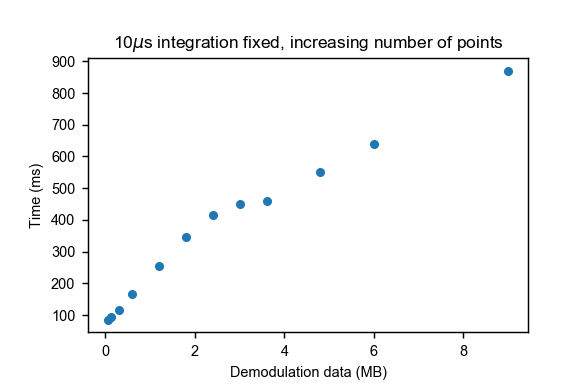

Text(0.5,1,'10$\\mu$s integration fixed, increasing number of points')

In [210]:
import matplotlib.pyplot as plt
MB_pp = 0.2e9*10e-6*2*12/8/1e6
pp = MB_pp*np.array([10,20,50,100,200,300,400,500,600,800,1000,1500])
t = np.array([85,94,116,167,256,345,415,450,460,550,640,870])
plt.figure()
plt.plot(pp,t, 'o')
plt.xlabel('Demodulation data (MB)')
plt.ylabel('Time (ms)')
plt.title(r'10$\mu$s integration fixed, increasing number of points')

In [236]:
print('frequency ' + str(1/(sequence.step_len()*sequence.voltage_points())) + " Hz")

#ivvi_setup.dac3(-6.5)
#ivvi.dac6(0)
#ivvi.dac7(-1200)
#cuttervals = np.linspace(0, 400, 101)
#plungervals = np.linspace(-1200, 200, 401)
t0 = time.clock()
exp = select_experiment('RT_test', 'none') # select experiment (info for the database)

# need to make sure the sweep is correctly described in the beginning!
meas = MeasurementExt(station, exp=exp,
                      hard_sweep_detector=detector,
                      #soft_sweep_params=[
                          #hetsrc.frequency,
                          #ivvi.dac7,
                          #ivvi.dac6,
                          #ami.field,
#                           ro_attenuator.attenuation,
                      #],
                     )

#meas.register_parameter(ivvi.dac7)
# and finally, the measurement loop
meas.write_period = 2 # how often to write to the DB [s]
t1 = time.clock()
print(t1-t0)
with meas.run() as datasaver:
    
    # this is to connect the database to the plottr.
    plot_subscriber = QcodesDatasetSubscriber(datasaver.dataset)
    datasaver.dataset.subscribe(plot_subscriber, state=[])
    
    # the loop itself is trivial
#     for att in ro_atts:
#         ro_attenuator.attenuation(att)
    #for f in [1, 1.5]:
        #ami.spherical([field,105,90])
    #for c in cuttervals:
        #ivvi.dac6(c)
        #for p in plungervals:
            #ivvi.dac7(p)
    t2 = time.clock()
    #print(t2-t1)
    detector.acquisition() # this gets the data from the alazar
    t3 = time.clock()
    print(t3-t2)
    datasaver.add_result(*meas.get_result()) # this adds all data to the datasaver.
    print(time.clock()-t2)

frequency 166.66666666666666 Hz
0.011734834766684799
Starting experimental run with id: 621
0.34579835731710773
0.3957024405608536


In [40]:
ami.spherical([0.75, 105, 90])

In [41]:
print('frequency ' + str(1/(sequence.step_len()*sequence.voltage_points())) + " Hz")

ivvi_setup.dac3(-6.5)
ivvi.dac6(0)
ivvi.dac7(-1200)
cuttervals = np.linspace(0, 400, 101)
plungervals = np.linspace(-1200, 200, 401)

exp = select_experiment('V0_0113A', 'dev48') # select experiment (info for the database)

# need to make sure the sweep is correctly described in the beginning!
meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          #hetsrc.frequency,
                          ivvi.dac7,
                          ivvi.dac6,
                          #ami.field,
#                           ro_attenuator.attenuation,
                      ],
                     )

#meas.register_parameter(ivvi.dac7)
# and finally, the measurement loop
meas.write_period = 2 # how often to write to the DB [s]
with meas.run() as datasaver:
    
    # this is to connect the database to the plottr.
    plot_subscriber = QcodesDatasetSubscriber(datasaver.dataset)
    datasaver.dataset.subscribe(plot_subscriber, state=[])
    
    # the loop itself is trivial
#     for att in ro_atts:
#         ro_attenuator.attenuation(att)
    #for f in [1, 1.5]:
        #ami.spherical([field,105,90])
    for c in cuttervals:
        ivvi.dac6(c)
        for p in plungervals:
            ivvi.dac7(p)
            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result()) # this adds all data to the datasaver.

frequency 100.0 Hz
Starting experimental run with id: 606


In [42]:
ami.spherical([0.5, 105, 90])

In [43]:
print('frequency ' + str(1/(sequence.step_len()*sequence.voltage_points())) + " Hz")

ivvi_setup.dac3(-6.5)
ivvi.dac6(0)
ivvi.dac7(-1200)
cuttervals = np.linspace(0, 400, 101)
plungervals = np.linspace(-1200, 200, 401)

exp = select_experiment('V0_0113A', 'dev48') # select experiment (info for the database)

# need to make sure the sweep is correctly described in the beginning!
meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          #hetsrc.frequency,
                          ivvi.dac7,
                          ivvi.dac6,
                          #ami.field,
#                           ro_attenuator.attenuation,
                      ],
                     )

#meas.register_parameter(ivvi.dac7)
# and finally, the measurement loop
meas.write_period = 2 # how often to write to the DB [s]
with meas.run() as datasaver:
    
    # this is to connect the database to the plottr.
    plot_subscriber = QcodesDatasetSubscriber(datasaver.dataset)
    datasaver.dataset.subscribe(plot_subscriber, state=[])
    
    # the loop itself is trivial
#     for att in ro_atts:
#         ro_attenuator.attenuation(att)
    #for f in [1, 1.5]:
        #ami.spherical([field,105,90])
    for c in cuttervals:
        ivvi.dac6(c)
        for p in plungervals:
            ivvi.dac7(p)
            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result()) # this adds all data to the datasaver.

frequency 100.0 Hz
Starting experimental run with id: 607


In [44]:
ami.spherical([0.25, 105, 90])

In [45]:
print('frequency ' + str(1/(sequence.step_len()*sequence.voltage_points())) + " Hz")

ivvi_setup.dac3(-6.5)
ivvi.dac6(0)
ivvi.dac7(-1200)
cuttervals = np.linspace(0, 400, 101)
plungervals = np.linspace(-1200, 200, 401)

exp = select_experiment('V0_0113A', 'dev48') # select experiment (info for the database)

# need to make sure the sweep is correctly described in the beginning!
meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          #hetsrc.frequency,
                          ivvi.dac7,
                          ivvi.dac6,
                          #ami.field,
#                           ro_attenuator.attenuation,
                      ],
                     )

#meas.register_parameter(ivvi.dac7)
# and finally, the measurement loop
meas.write_period = 2 # how often to write to the DB [s]
with meas.run() as datasaver:
    
    # this is to connect the database to the plottr.
    plot_subscriber = QcodesDatasetSubscriber(datasaver.dataset)
    datasaver.dataset.subscribe(plot_subscriber, state=[])
    
    # the loop itself is trivial
#     for att in ro_atts:
#         ro_attenuator.attenuation(att)
    #for f in [1, 1.5]:
        #ami.spherical([field,105,90])
    for c in cuttervals:
        ivvi.dac6(c)
        for p in plungervals:
            ivvi.dac7(p)
            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result()) # this adds all data to the datasaver.

frequency 100.0 Hz
Starting experimental run with id: 608


In [46]:
ami.spherical([0, 105, 90])

In [47]:
print('frequency ' + str(1/(sequence.step_len()*sequence.voltage_points())) + " Hz")

ivvi_setup.dac3(-6.5)
ivvi.dac6(0)
ivvi.dac7(-1200)
cuttervals = np.linspace(0, 400, 101)
plungervals = np.linspace(-1200, 200, 401)

exp = select_experiment('V0_0113A', 'dev48') # select experiment (info for the database)

# need to make sure the sweep is correctly described in the beginning!
meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=detector,
                      soft_sweep_params=[
                          #hetsrc.frequency,
                          ivvi.dac7,
                          ivvi.dac6,
                          #ami.field,
#                           ro_attenuator.attenuation,
                      ],
                     )

#meas.register_parameter(ivvi.dac7)
# and finally, the measurement loop
meas.write_period = 2 # how often to write to the DB [s]
with meas.run() as datasaver:
    
    # this is to connect the database to the plottr.
    plot_subscriber = QcodesDatasetSubscriber(datasaver.dataset)
    datasaver.dataset.subscribe(plot_subscriber, state=[])
    
    # the loop itself is trivial
#     for att in ro_atts:
#         ro_attenuator.attenuation(att)
    #for f in [1, 1.5]:
        #ami.spherical([field,105,90])
    for c in cuttervals:
        ivvi.dac6(c)
        for p in plungervals:
            ivvi.dac7(p)
            detector.acquisition() # this gets the data from the alazar
            datasaver.add_result(*meas.get_result()) # this adds all data to the datasaver.

frequency 100.0 Hz
Starting experimental run with id: 609


In [48]:
ivvi.set_dacs_zero()

In [26]:
fg.ch1.burst.trigger()

In [156]:
fg.ch1.burst.source('MAN')

In [157]:
fg.ch1.burst.on('ON')

In [27]:
for i in range(50):
    fg.ch1.burst.trigger()
    time.sleep(1)

In [127]:
fg.ch1.freq(500)

In [362]:
data = acq.acquisition()

RuntimeError: ('error 579: ApiWaitTimeout: operation did not finish during timeout interval. Check your trigger. from function AlazarWaitAsyncBufferComplete with args: [2584, c_void_p(2903496196096), 10000]', 'getting avgiq_acq_acquisition')

In [205]:
data.shape

(401, 2)

In [286]:
for i in range(10):
    data = acq.acquisition()
    time.sleep(0.1)

RuntimeError: ('error 579: ApiWaitTimeout: operation did not finish during timeout interval. Check your trigger. from function AlazarWaitAsyncBufferComplete with args: [2584, c_void_p(2903496196096), 10000]', 'getting avgiq_acq_acquisition')